<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/LSTM_garret_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
%pip install --upgrade pip
%pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html optax flax

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [130]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
from functools import partial

In [131]:
## Importação do histórico - UNISIM
df = pd.read_excel('/content/drive/MyDrive/UNISIM/dataset_unisim.xlsx')
df.head()

,t,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
0,0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
1,31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
2,62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
3,92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
4,123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327


In [132]:
df.shape

(132, 11)

In [133]:
df.index = df['t']
t = df['t']
df.drop('t', axis=1, inplace=True)
df

,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
t,,,,,,,,,,
0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327
...,...,...,...,...,...,...,...,...,...,...
3867,24757936,2793256452,4393983,36864922,1.398615,0.003554,113.06,0.695071,0.025850,305
3896,25022300,2822363056,4583991,37475894,1.398453,0.003542,113.06,0.692879,0.025905,306
3927,25304090,2853787229,4789676,38123794,1.398291,0.003530,113.06,0.690695,0.025960,307


In [134]:
df.shape

(132, 10)

<Axes: xlabel='t'>

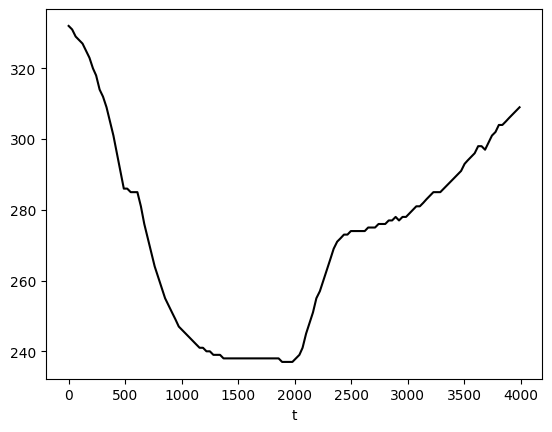

In [135]:
press = df['p']
press.plot(color='black')

In [136]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
# scaled_data = df.to_numpy()

# Define sequence length and features
window_size = 5  # Number of time steps in each sequence
features = len(df.columns)

scaled_data.shape

(132, 10)

In [137]:
# Create sequences and corresponding labels
X = []
y = []
for i in range(len(scaled_data) - window_size):
    seq = scaled_data[i:i+window_size]
    label = scaled_data[i+window_size][-1]
    X.append(seq)
    y.append(label)

In [138]:
# Convert to jax numpy arrays
X = jnp.array(X)
y = jnp.array(y)
X.shape, y.shape

((127, 5, 10), (127,))

In [139]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size
train_size, val_size, test_size

(88, 19, 20)

In [140]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((88, 5, 10), (88,), (19, 5, 10), (19,), (20, 5, 10), (20,))

In [297]:
# Definir a rede LSTM usando Flax
class LSTM(nn.Module):
    @nn.compact
    def __call__(self, x):
        input_shape = x[0].shape
        lstm = nn.OptimizedLSTMCell(128)
        carry = lstm.initialize_carry(jax.random.PRNGKey(0), input_shape)
        for i in range(x.shape[0]):
          if i < (x.shape[0] - 1):
            carry, _ = lstm(carry, x[i])
          else:
            _, x = lstm(carry, x[i])
        x = nn.Dense(8)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Initialize the random key
rng_key = random.PRNGKey(42)

class LSTMnet(LSTM):
    def setup(self):
        super().setup()

# Define the Neural Network
model = LSTMnet()

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
dummy_input = jnp.zeros(X_train[0].shape)
params = model.init(init_key, dummy_input)

## Define the optimizer using Optax
lr = 0.01
# lr = optax.exponential_decay(init_value=1e-3,
#                              transition_steps=1000,
#                              decay_rate=0.98)
tx = optax.adam(learning_rate=lr)

# Create the training state
state = TrainState.create(
    apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
    # apply_fn=model.apply,
    params=params,
    tx=tx)

# Print the model structure in a fancy way
print(model.tabulate(rng_key, dummy_input))


                                          LSTMnet Summary                                           
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path              ┃ module            ┃ inputs           ┃ outputs           ┃ params            ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│                   │ LSTMnet           │ float32[5,10]    │ float32[1]        │                   │
├───────────────────┼───────────────────┼──────────────────┼───────────────────┼───────────────────┤
│ OptimizedLSTMCel… │ OptimizedLSTMCell │ - - float32[128] │ - - float32[128]  │                   │
│                   │                   │   - float32[128] │   - float32[128]  │                   │
│                   │                   │ - float32[10]    │ - float32[128]    │                   │
├───────────────────┼───────────────────┼──────────────────┼───────────────────┼──────────

In [298]:
# Solução para 1 exemplo de teste
x_single = X_train[0]
u = state.apply_fn(params, x_single)
u

Array(-0.00733811, dtype=float32)

In [299]:
u.shape

()

In [300]:
# Solução para todo o dataset de treinamento

u_pred_vmap = vmap(state.apply_fn, (None, 0))(state.params, X_train)
u_pred_vmap

Array([-0.00733812, -0.01187937, -0.0171181 , -0.02472548, -0.03182342,
       -0.04172198, -0.05019529, -0.05940865, -0.07090113, -0.08381294,
       -0.09926227, -0.11622125, -0.13386762, -0.14254954, -0.14826465,
       -0.15059732, -0.15141734, -0.15874293, -0.17147325, -0.19971925,
       -0.22952127, -0.2587507 , -0.28293902, -0.30426207, -0.3239311 ,
       -0.3394931 , -0.35256335, -0.36438948, -0.37535247, -0.3831923 ,
       -0.38937876, -0.39476156, -0.39962927, -0.40412045, -0.40849617,
       -0.41071346, -0.41369954, -0.41530305, -0.41785246, -0.4191876 ,
       -0.41978508, -0.4218457 , -0.4230602 , -0.4233945 , -0.42361733,
       -0.42380342, -0.42378026, -0.4237734 , -0.4237734 , -0.4237734 ,
       -0.4237734 , -0.4237734 , -0.4237734 , -0.4237734 , -0.4237734 ,
       -0.4237734 , -0.4237734 , -0.42374787, -0.42549804, -0.42649072,
       -0.4268292 , -0.42697978, -0.42515635, -0.4218132 , -0.41576225,
       -0.40339038, -0.3884911 , -0.37195987, -0.3509286 , -0.33

In [301]:
u_pred_vmap.shape

(88,)

In [302]:
@jit
def train_step(state, batch):
    def loss_fn(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        return jnp.mean(jnp.square(u_pred - batch['u']))
    loss, grads = value_and_grad(loss_fn)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return loss, state

@jit
def eval_step(state, batch):
    def eval_error(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        # return jnp.linalg.norm(x=(u_pred - batch['u']), ord=2) / jnp.linalg.norm(x=batch['u'], ord=2)
        return jnp.mean(jnp.square(u_pred - batch['u']))
    return eval_error(state.params, batch)

In [303]:
train_batch = {'x': X_train, 'u': y_train}
eval_batch = {'x': X_val, 'u': y_val}

In [304]:
loss_log = []
epoch_log = []
error_log = []

for epoch in range(500):
  loss, state = train_step(state, train_batch)
  if epoch%100 == 0:
    epoch_log.append(epoch)
    loss_log.append(loss)
    eval_error = eval_step(state, eval_batch)
    error_log.append(eval_error)
    print(f"Epoch: {epoch} -- Loss: {loss} -- Error: {eval_error}")

Epoch: 0 -- Loss: 0.3080170750617981 -- Error: 0.04067400097846985
Epoch: 100 -- Loss: 0.0002823203685693443 -- Error: 0.0008803321979939938
Epoch: 200 -- Loss: 0.00010361011663917452 -- Error: 0.0012553572887554765
Epoch: 300 -- Loss: 0.00011945300502702594 -- Error: 0.0003117472224403173
Epoch: 400 -- Loss: 8.800032082945108e-05 -- Error: 0.000574636971578002


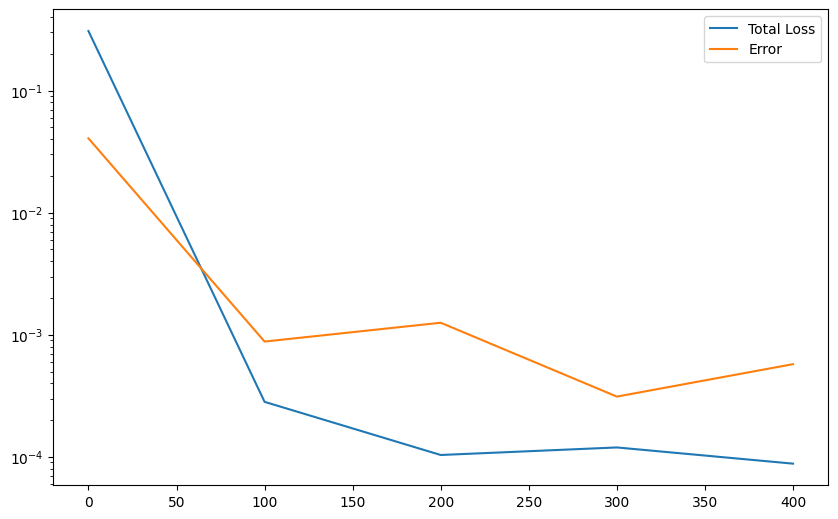

In [305]:
# Plot training & validation loss values
fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.plot(epoch_log, loss_log, label='Total Loss')
ax.plot(epoch_log, error_log, label='Error')
ax.set_yscale('log')
ax.legend()

In [306]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict temperatures using the trained model
predictions = vmap(state.apply_fn, (None, 0))(state.params, X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.050893657
Mean Squared Error (MSE): 0.002656771
Root Mean Squared Error (RMSE): 0.051543877


In [307]:
test_predictions = vmap(state.apply_fn, (None, 0))(state.params, X_test)
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

,Test Predictions,Actuals
0,0.509406,0.547368
1,0.517598,0.557895
2,0.526276,0.568421
3,0.535619,0.589474
4,0.552968,0.600000
5,0.561545,0.610526
6,0.571026,0.621053
7,0.580567,0.642105
8,0.597995,0.642105
9,0.599650,0.631579


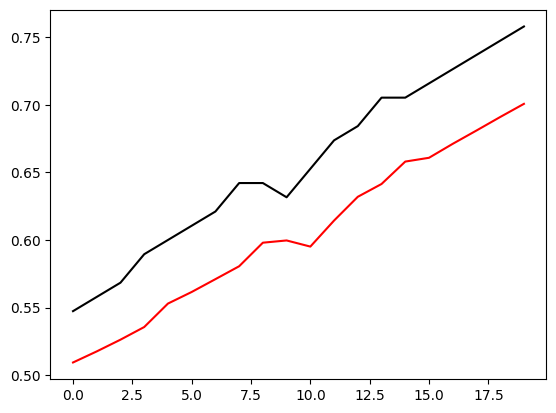

In [308]:
plt.plot(test_results['Test Predictions'], color='red')
plt.plot(test_results['Actuals'], color='black')

(     Predictions   Actuals
 0       0.922342  0.926316
 1       0.902695  0.905263
 2       0.880434  0.873684
 3       0.850365  0.852632
 4       0.823135  0.810526
 ..           ...       ...
 122     0.660784  0.715789
 123     0.671108  0.726316
 124     0.680942  0.736842
 125     0.690946  0.747368
 126     0.700675  0.757895
 
 [127 rows x 2 columns],
 0.00051374245)

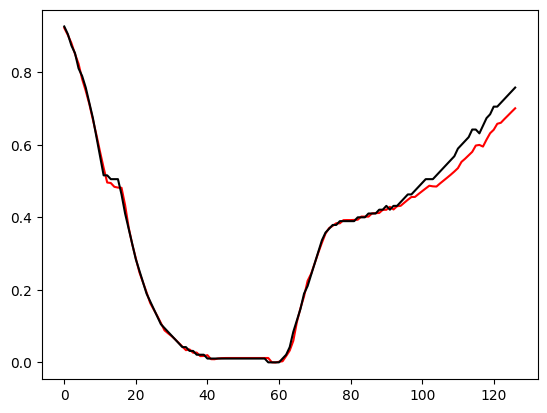

In [309]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(model, X, y, start=0, end=100):
  predictions = vmap(state.apply_fn, (None, 0))(state.params, X)
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], color='red')
  plt.plot(df['Actuals'][start:end], color='black')
  return df, mse(predictions, y)

plot_predictions(model, X, y, 0, len(X))

In [310]:
# y_true values
y_copies = np.repeat(y.reshape(-1, 1), X.shape[-1], axis=-1)
true_y = scaler.inverse_transform(y_copies)

# predicted values
y_pred = vmap(state.apply_fn, (None, 0))(state.params, X)
true_y_pred_copies = np.repeat(y_pred.reshape(-1, 1), X.shape[-1], axis=-1)
true_y_pred = scaler.inverse_transform(true_y_pred_copies)

In [311]:
(true_y[:, -1] - press.values[window_size:]).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [312]:
ts = t[1:true_y[:, -1].shape[0]+1]

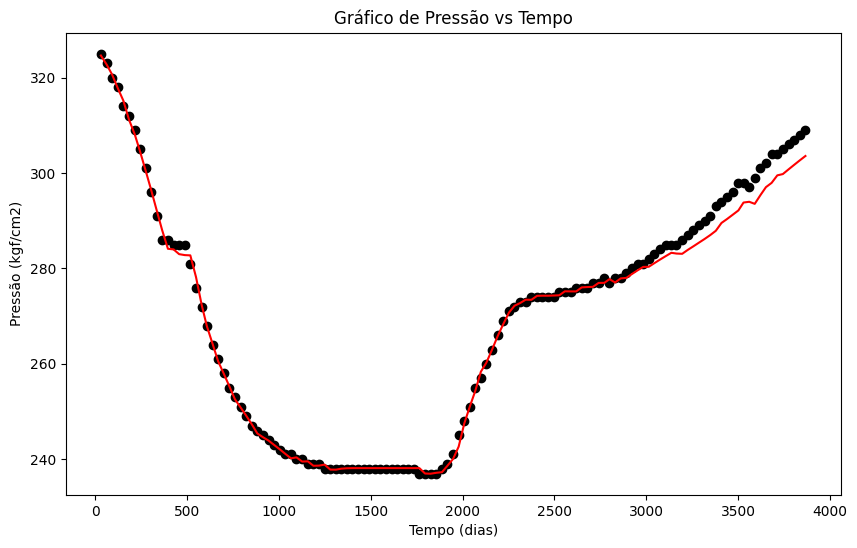

In [313]:
# Plota gráfico do histórico de p x t

plt.figure(figsize=(10, 6))
plt.scatter(ts, true_y[:, -1], color='black')
plt.plot(ts, true_y_pred[:, -1], color='red')
plt.xlabel('Tempo (dias)')
plt.ylabel('Pressão (kgf/cm2)')
plt.title('Gráfico de Pressão vs Tempo')
plt.show()